In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/Binance_BTCUSDT_minute.csv', index_col='date', parse_dates=True)
df = df.drop(['unix', 'symbol'], axis=1)

df = df.iloc[::-1]
df.head()

,open,high,low,close,Volume BTC,Volume USDT,tradecount
date,,,,,,,
2019-09-08 17:57:00,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1
2019-09-08 17:58:00,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
2019-09-08 17:59:00,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1
2019-09-08 18:00:00,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
2019-09-08 18:01:00,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1317061 entries, 2019-09-08 17:57:00 to 2022-03-15 03:06:00
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   open         1317061 non-null  float64
 1   high         1317061 non-null  float64
 2   low          1317061 non-null  float64
 3   close        1317061 non-null  float64
 4   Volume BTC   1317061 non-null  float64
 5   Volume USDT  1317061 non-null  float64
 6   tradecount   1317061 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 80.4 MB


In [19]:
df['2020':'2022'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152539 entries, 2020-01-01 00:00:00 to 2022-03-15 03:06:00
Data columns (total 21 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Open           1152539 non-null  float64
 1   High           1152539 non-null  float64
 2   Low            1152539 non-null  float64
 3   Close          1152539 non-null  float64
 4   Volume btc     1152539 non-null  float64
 5   Volume usdt    1152539 non-null  float64
 6   Tradecount     1152539 non-null  int64  
 7   X_SMA10        1152539 non-null  float64
 8   X_SMA20        1152539 non-null  float64
 9   X_SMA50        1152539 non-null  float64
 10  X_SMA100       1152539 non-null  float64
 11  X_DELTA_SMA10  1152539 non-null  float64
 12  X_DELTA_SMA20  1152539 non-null  float64
 13  X_DELTA_SMA50  1152539 non-null  float64
 14  X_MOM          1152539 non-null  float64
 15  X_BB_upper     1152539 non-null  float64
 16  X_BB_lower     115253

In [5]:
# Brute-force Strategy
class Agent:
    TAX = 0.001
    BOUNCING_COEF = 1.01
    
    def __init__(self, st_price, cash=0.0, crypto=0.0):
        self.high = self.low = st_price
        self.last_buy_price = self.last_sell_price = st_price
        
        self.cash = cash
        self.crypto = crypto
        
        self.up_rate = self.down_rate = 1.0
        self.last_up_rate = self.last_down_rate= 1.0
        
        self.trades_count = 0
        self.last_trade = 'sell' if cash else 'buy'
        self.buy_l = []
        self.sell_l = []
    
    def buy(self, price):
        if self.cash > 0.0:
            self.crypto += (1-Agent.TAX) * self.cash / price
            self.cash = 0.0
            self.last_buy_price = price
            self.last_trade = 'buy'
            return True
        
        return False     
    
    
    def sell(self, price):
        if self.crypto > 0.0: # > (10.0 / buy_price):
            self.cash += (1-Agent.TAX) * self.crypto * price
            self.crypto = 0.0
            self.last_sell_price = price
            self.last_trade = 'sell'
            self.trades_count += 1
            return True

        return False
    
    def profit(self):
        return self.cash + self.crypto * self.last_buy_price
    
    def __str__(self):
        return f'''
        PROFIT = {self.profit()} $
        CASH = {self.cash} $
        CRYPTO = {self.crypto}
        HIGH = {self.high}, LOW = {self.low}
        TRADES_COUNT = {self.trades_count}
        LAST_TRADE = {self.last_trade}
        LBP = {self.last_buy_price}, LSP = {self.last_sell_price}
        '''
        
        
    def trade(self, price):
        # print(self)
        if price < self.low:
            self.low = price
            self.last_down_rate = self.high / price
        
        if price > self.high:
            self.high = price
            self.last_up_rate = price / self.low
            
            
        if self.last_trade == 'sell':
            self.down_rate = self.high / price
            # print('SELL', self.last_down_rate / self.down_rate )
            if self.last_down_rate / self.down_rate > Agent.BOUNCING_COEF:
                if self.buy(price):
                    self.high = price
                    self.buy_l.append(price)
            else:
                self.buy_l.append(np.nan)
            
            self.sell_l.append(np.nan)
                # self.last_up_rate = 1.0
                
        else: # self.last_trade == 'buy'
            if price > self.last_buy_price:
                self.up_rate = price / self.low
                if self.up_rate > 1.25 and self.last_up_rate / self.up_rate > Agent.BOUNCING_COEF:
                    if self.sell(price):
                        self.low = price
                        # self.last_down_rate = 1.0
                        self.sell_l.append(price)
                else:
                    self.sell_l.append(np.nan)
                    
                self.buy_l.append(np.nan)


agent_1 = Agent(st_price=df['close'][75], cash=100)
agent_2 = Agent(st_price=df['close'][75], crypto=50/df['close'][75])

for val in df['close'][75:]:
    agent_1.trade(val)
    agent_2.trade(val)
    
# print(agent_1.trades_count, agent_1.cash)    
# print(agent_2.trades_count, agent_2.cash)    

print(agent_1)

# plt.figure(figsize=(24, 8))

# plt.scatter(df.index[76:1000], agent_1.buy_l, label='Buy', color='green', marker='^', alpha=1)
# plt.scatter(df.index[76:1000], agent_1.sell_l, label='Sell', color='red', marker='v', alpha=1)

# plt.plot(df['close'][75:1000], label='Close', color='blue', alpha=0.35)
# plt.show()


# print(agent_1.sell)


        PROFIT = 601.0029293073461 $
        CASH = 0.0 $
        CRYPTO = 0.009067574666547167
        HIGH = 69000.0, LOW = 33056.98
        TRADES_COUNT = 14
        LAST_TRADE = buy
        LBP = 66280.45, LSP = 66219.99
        


In [6]:
# 0.004106413797843543*65987.87
# df['close'][75:1000].min()
len(df['close'][75:]) / 1440

914.5736111111111

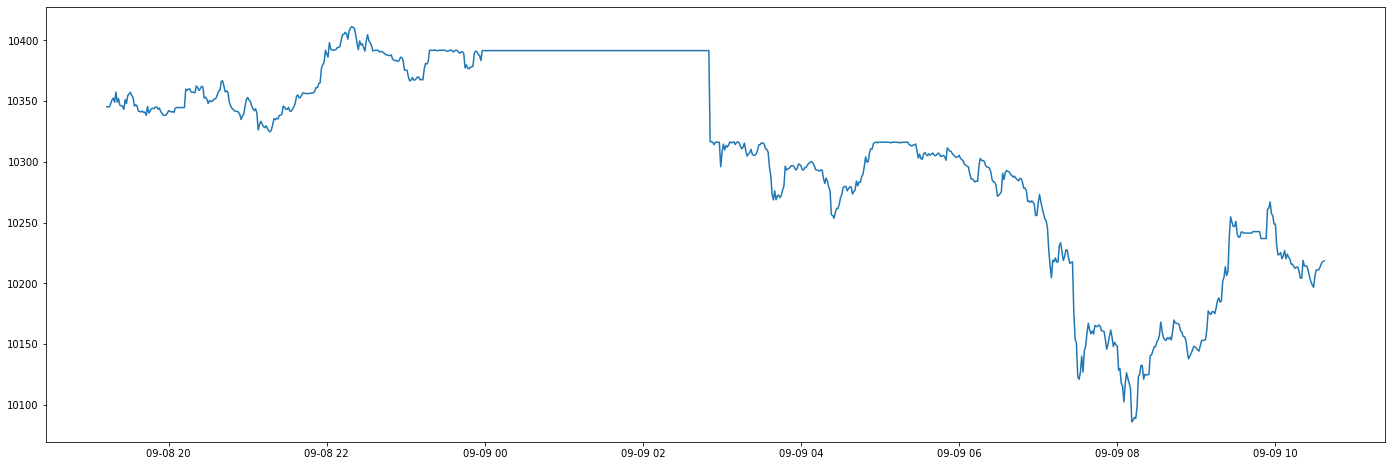

1.0012567672080432

In [7]:
plt.figure(figsize=(24, 8))
plt.plot(df['close'][75: 1000])
plt.show()
10357/10344

In [8]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

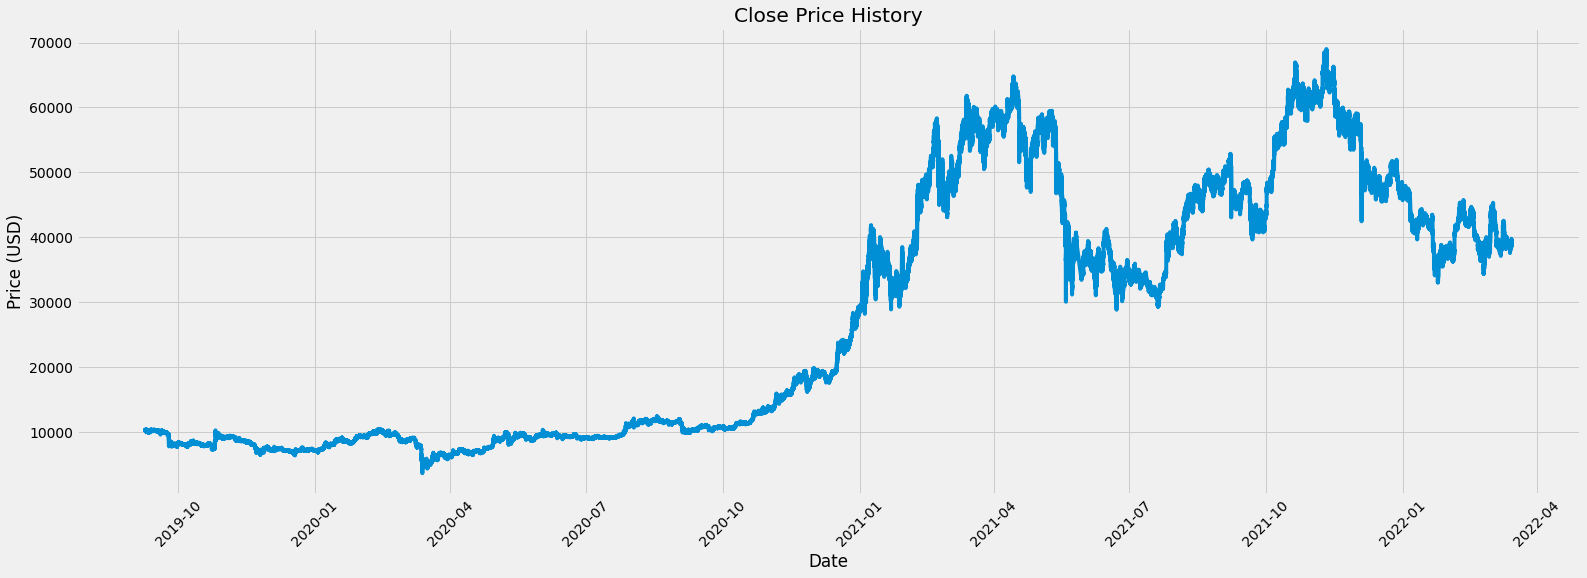

In [9]:
plt.figure(figsize=(24, 8))
plt.plot(df['close'], label='Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price (USD)')
plt.title('Close Price History')
plt.show()

In [10]:
short_ema = df.iloc[:1440, 3].ewm(span=12, adjust=False).mean()
long_ema = df.iloc[:1440, 3].ewm(span=26, adjust=False).mean()

macd = short_ema - long_ema
signal = macd.ewm(span=9, adjust=False).mean()

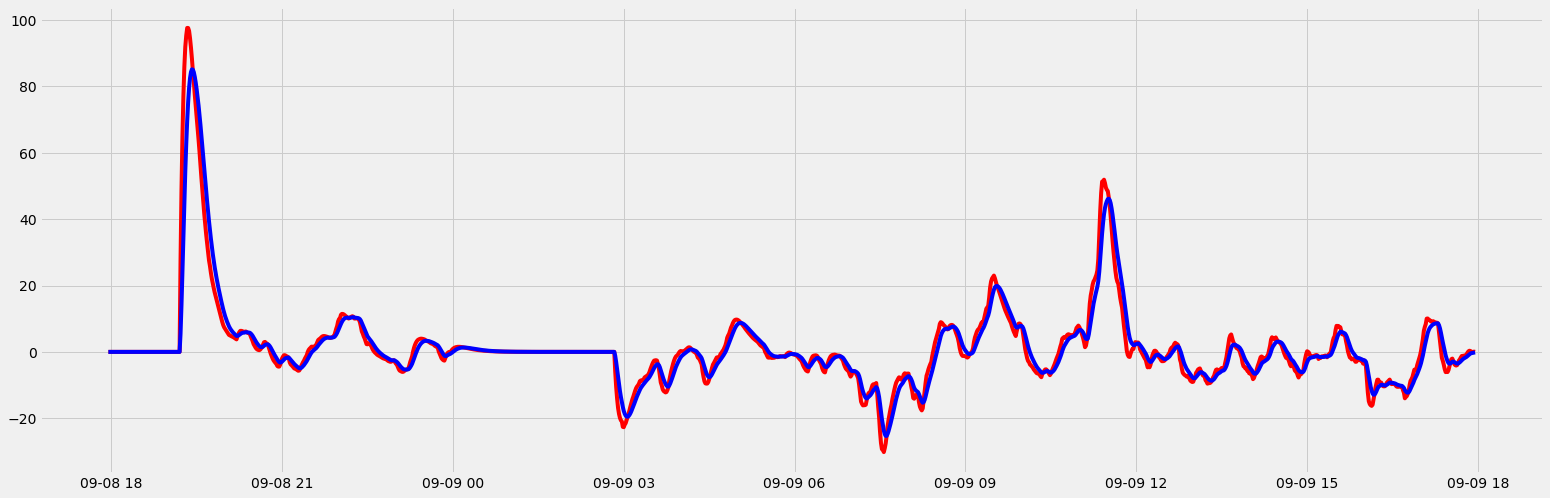

In [11]:
plt.figure(figsize=(24, 8))

plt.plot(df.index[:1440], macd, label='MACD', color='red')
plt.plot(df.index[:1440], signal, label='Signal Line', color='blue')

plt.show()

In [12]:
def buy_sell(macd, signal):
    buy = []
    sell = []
    flag = -1
    
    for i in range(len(macd)):
        if macd[i] > signal[i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(df['close'][i])
                flag = 1
            else:
                buy.append(np.nan)
         
        if macd[i] < signal[i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(df['close'][i])
                flag = 0
            else:
                sell.append(np.nan)
         
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            
    return buy, sell                

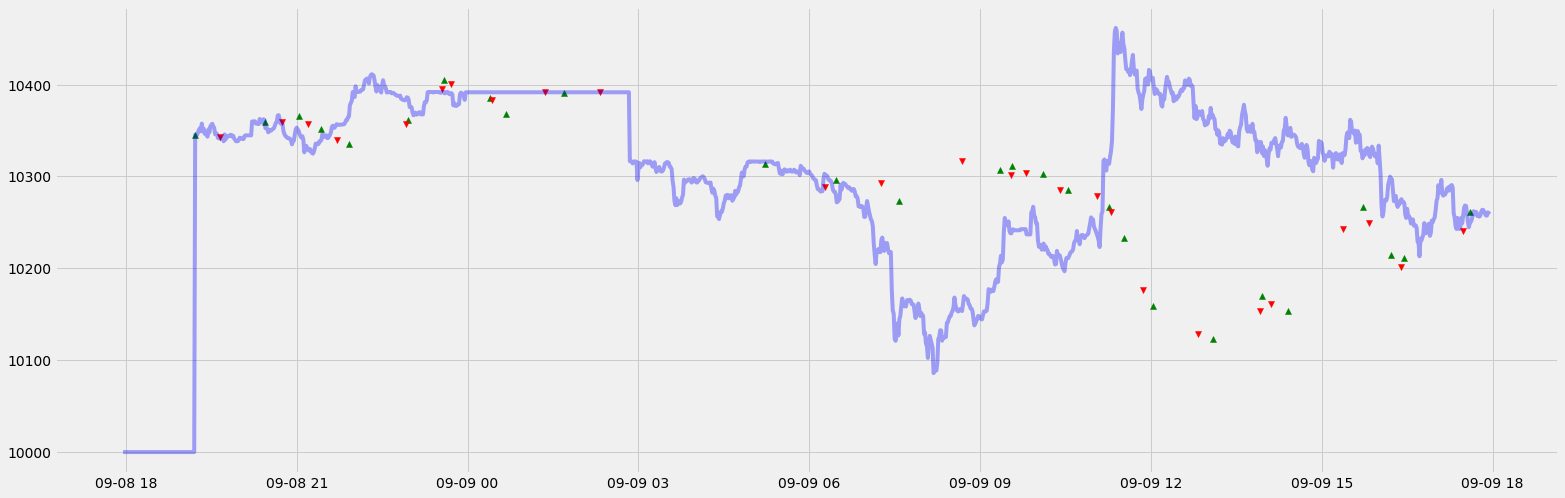

In [13]:
a = buy_sell(macd, signal)

plt.figure(figsize=(24, 8))

plt.scatter(df.index[:1440], a[0][:1440], label='Buy', color='green', marker='^', alpha=1)
plt.scatter(df.index[:1440], a[1][:1440], label='Sell', color='red', marker='v', alpha=1)

plt.plot(df['close'][:1440], label='Close', color='blue', alpha=0.35)
# plt.plot(df.index[:1440], signal, label='Signal Line', color='blue')

plt.show()

Note: you may need to restart the kernel to use updated packages.


In [15]:
from backtesting.test import SMA

df.columns = df.columns.str.capitalize()
data = df
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

/home/ahmad/.local/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [16]:
def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

In [17]:
%%time

from backtesting import Backtest, Strategy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

<timed exec>:63: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).


CPU times: user 22min 18s, sys: 3.83 s, total: 22min 22s
Wall time: 22min 25s


Start                     2019-09-08 19:37:00
End                       2022-03-15 03:06:00
Duration                    918 days 07:29:00
Exposure Time [%]                    5.742383
Equity Final [$]                  17395.17487
Equity Peak [$]                  32571.130496
Return [%]                          73.951749
Buy & Hold Return [%]              276.761903
Return (Ann.) [%]                    24.59233
Volatility (Ann.) [%]               52.069155
Sharpe Ratio                         0.472301
Sortino Ratio                        0.802613
Calmar Ratio                         0.479804
Max. Drawdown [%]                  -51.254907
Avg. Drawdown [%]                    -1.38601
Max. Drawdown Duration      195 days 23:46:00
Avg. Drawdown Duration        2 days 03:56:00
# Trades                                 2624
Win Rate [%]                        53.467988
Best Trade [%]                       0.501354
Worst Trade [%]                     -0.563908
Avg. Trade [%]                    

In [18]:
df.columns.str.capitalize()

Index(['Open', 'High', 'Low', 'Close', 'Volume btc', 'Volume usdt',
       'Tradecount', 'X_sma10', 'X_sma20', 'X_sma50', 'X_sma100',
       'X_delta_sma10', 'X_delta_sma20', 'X_delta_sma50', 'X_mom',
       'X_bb_upper', 'X_bb_lower', 'X_bb_width', 'X_sentiment', 'X_day',
       'X_hour'],
      dtype='object')